In [4]:
import finnhub
import pandas as pd
import numpy as np
from numpy import log
import time
from time import mktime
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings("ignore")

sns.set_theme() # Definir estilo
sns.set_context("paper")

# Importar datos

In [5]:
# Contectar a finnhub para los datos de Bitcoin
finnhub_client = finnhub.Client(api_key="cl16qc9r01qoeujumlq0cl16qc9r01qoeujumlqg")
stock = 'BTC' 
resolution = 'D' # resolución diaria

end_date = datetime.now() # fecha actual
start_date = datetime(2020, 10, 10)  

end = int(end_date.timestamp())
start = int(start_date.timestamp())

# Crear un Dataframe con los datos
BTC_res = finnhub_client.stock_candles(stock, resolution, start, end)
BTC_df = pd.DataFrame(BTC_res)

# Cambiar formato de fecha, que esta en formato unix time
def date_format(date_col):
    return datetime.fromtimestamp(date_col).strftime('%Y-%m-%d')
date_format(1602460800)
# Aplicar la funcion creada a toda la columna y visualizar nuevamente con el formato de fecha
BTC_df['t'] = BTC_df['t'].apply(date_format)
# Cambiar los nombres de las columnas y eliminar columna s que no proporciona información para las predicciones
BTC_df.rename(columns = {'c':'Close','h':'High','l':'Low','o':'Open','t':'Date','v':'Volume'}, inplace = True)
BTC_df.drop('s', axis=1, inplace = True)
BTC_df.head()

,Close,High,Low,Open,Date,Volume
0,99.2447,100.89,98.770,100.890,2021-04-15,4517
1,99.1012,99.13,98.985,99.120,2021-04-18,4561
2,99.0441,99.30,98.790,98.790,2021-04-19,3736
3,98.9705,99.01,98.900,99.010,2021-04-20,997
4,99.0010,99.04,98.860,98.925,2021-04-21,1599


En este fragmento de código, se establece una conexión con la API de Finnhub para obtener datos relacionados con Bitcoin (BTC). Luego, se define una resolución diaria y se selecciona un rango de fechas hasta la fecha actual. Los datos se almacenan en un DataFrame de Pandas, y se aplica una función para formatear la columna de fechas en un formato legible. Además, se renombran las columnas relevantes y se elimina una columna que no contribuye a las predicciones. El DataFrame resultante muestra las primeras filas de datos que incluyen información sobre el precio de cierre, máximo, mínimo, apertura, fecha y volumen de Bitcoin.

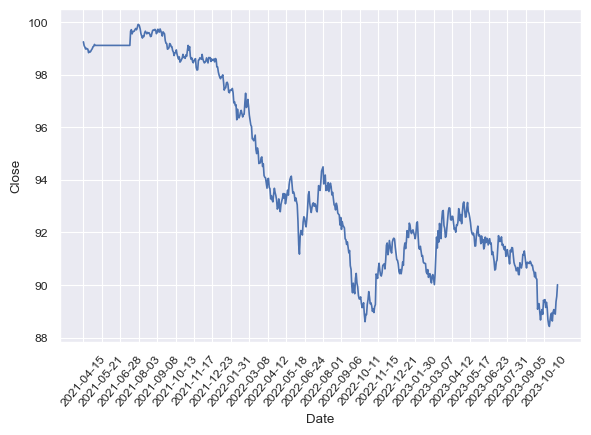

In [6]:
# Visualizar la serie de serie de tiempo
plt.figure(figsize = (6,4))
ax = sns.lineplot(data=BTC_df, x="Date", y="Close")
freq = int(25) # Frencuencia de cada 15 dias para las etiquetas
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq]) # Cambiar la frecuencia de las etiquetas del eje x
plt.tight_layout()
plt.xticks(rotation=50); 

La serie temporal de precios de Bitcoin (BTC) exhibe una tendencia claramente bajista a lo largo del período analizado. 

In [7]:
# Gráfico de velas para mejor visualización
fig = go.Figure(data=[go.Candlestick(x = BTC_df.Date,
                                     open = BTC_df.Open, 
                                     high = BTC_df.High,
                                     low = BTC_df.Low, 
                                     close = BTC_df.Close)
                     ])
fig.update_layout(
    title="Bitcoin Candlestick Chart",
    xaxis_title="Day",
    yaxis_title="BTC-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [8]:
# Prueda Dickey-Fuller para confirmar si la serie es estacionaria o no 
result = adfuller(BTC_df.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.015149
p-value: 0.747699


Según la prueba de Dickey-Fuller, el valor de la estadística ADF es -1.015149 y el valor p es 0.747699, que supera el nivel de significancia típico de 0.05 (5%). Con estos resultados se sugiere que la serie de tiempo de Bitcoin no es estacionaria, lo que indica la presencia de una tendencia en los datos.

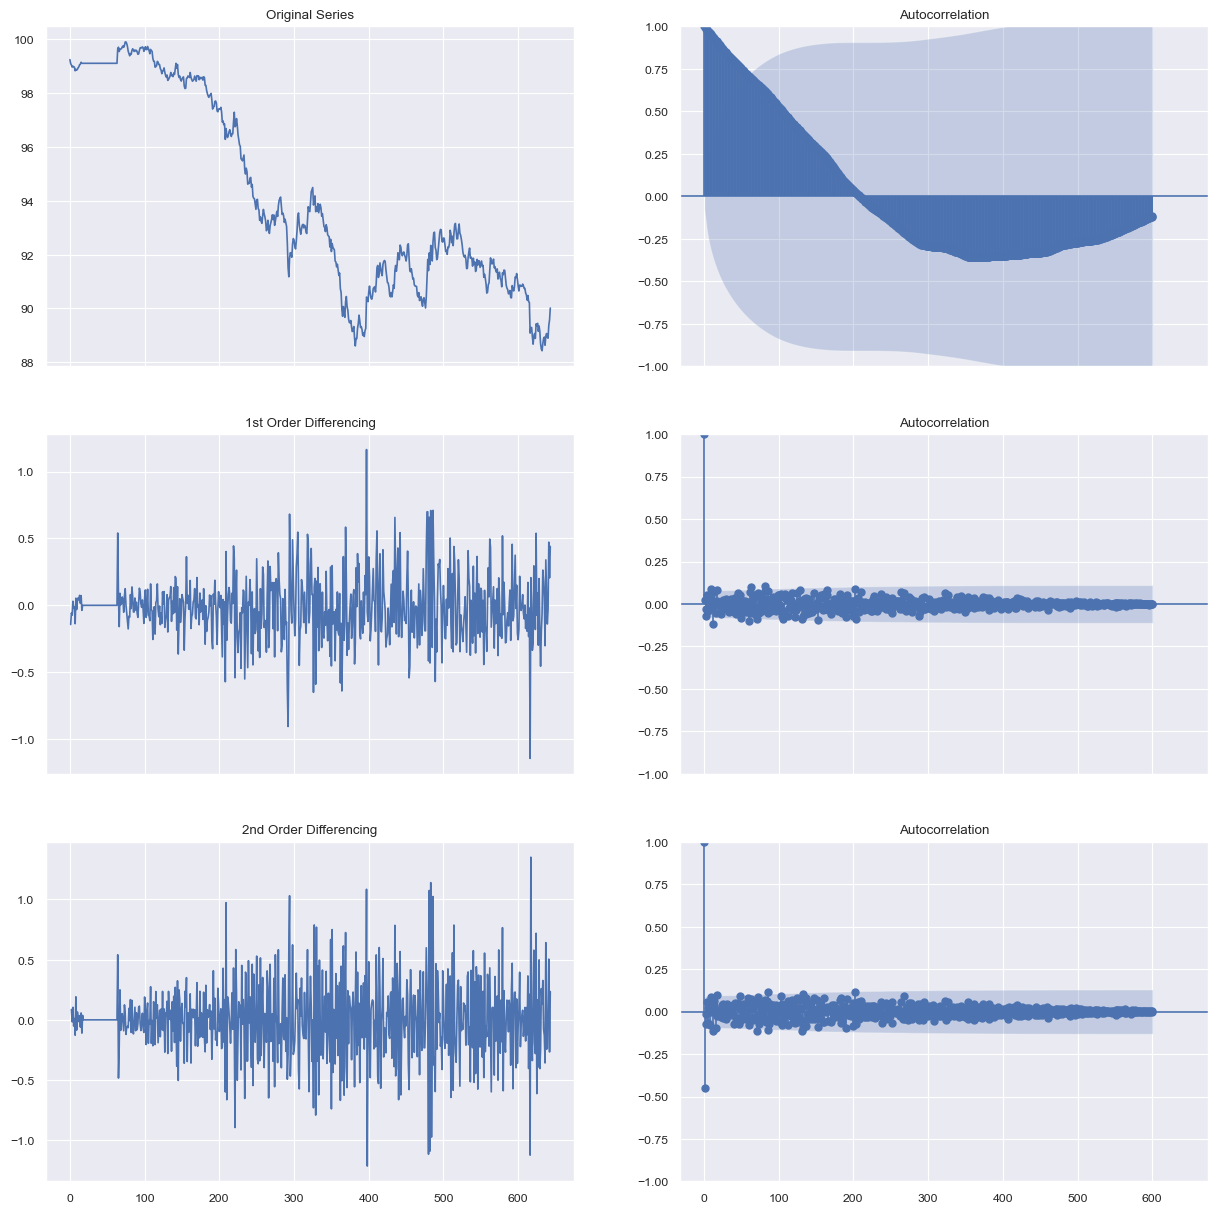

In [9]:
# Diferenciación
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(BTC_df.Close); axes[0, 0].set_title('Original Series')
plot_acf(BTC_df.Close, ax=axes[0, 1], lags = 600);

axes[1, 0].plot(BTC_df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(BTC_df.Close.diff().dropna(), ax=axes[1, 1], lags =600);

axes[2, 0].plot(BTC_df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(BTC_df.Close.diff().diff().dropna(), ax=axes[2, 1], lags = 600);

La gráfica presenta una serie de transformaciones aplicadas a la serie temporal original de precios de cierre de Bitcoin (BTC).

En la serie original se observa una tendencia de disminución con fluctuaciones notables a lo largo del tiempo. Tras la primera diferencia, estas fluctuaciones parecen haberse atenuado, y la serie muestra signos de mayor estacionariedad. La segunda diferencia se aplica para suavizar aún más la serie, reduciendo las fluctuaciones restantes. Estas transformaciones son esenciales para preparar los datos antes de ajustar un modelo ARIMA, ya que ayudan a eliminar tendencias y patrones no deseados, y reducir la autocorrelación en la serie temporal.

# Modelo ARIMA

**Funciones para el modelo**

In [10]:
# Definir rangos
pq_rng = range(5)
d_rng = range(3)

# Función para encontrar los mejores órdenes de ARIMA para AIC - BIC - HQIC
def find_best_arima_order(train, pq_rng, d_rng):
    best_aic = np.inf
    best_order_aic = None
    best_mdl_aic = None
    
    best_bic = np.inf
    best_order_bic = None
    best_mdl_bic = None
    
    best_bhqic = np.inf
    best_order_hqic = None
    best_mdl_hqic = None
    
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    tmp_mdl = ARIMA(train, order=(p, d, q)).fit()
                    tmp_aic = tmp_mdl.aic
                    tmp_bic = tmp_mdl.bic
                    tmp_hqic = tmp_mdl.hqic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order_aic = (p, d, q)
                        best_mdl_aic = tmp_mdl
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order_bic = (p, d, q)
                        best_mdl_bic = tmp_mdl
                    if tmp_hqic < best_bhqic:
                        best_hqic = tmp_hqic
                        best_order_hqic = (p, d, q)
                        best_mdl_hqic = tmp_mdl
                except:
                    continue

    return best_order_aic, best_mdl_aic, best_order_bic, best_mdl_bic, best_order_hqic, best_mdl_hqic


# Función para evaluar el modelo ARIMA y obtener predicciones
def evaluate_arima_model(train, test, best_order):
    model = ARIMA(train, order=best_order)
    model_fit = model.fit()
    predictions = arima_rolling(train.tolist(), test.tolist(), best_order)
    accuracy = forecast_accuracy(np.array(test), np.array(predictions), f"Horizonte {len(test)}")
    return accuracy, predictions

# Función para realizar predicciones con modelo ARIMA
def arima_rolling(history, test, order):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('Predicted=%f, Expected=%f' % (yhat, obs))
    return predictions

# Función para calcular métricas de precisión de pronóstico
def forecast_accuracy(forecast, actual, str_name):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual) ** 2) ** 0.5
    mse = np.mean((forecast - actual) ** 2)
    r2 = r2_score(forecast, actual)

    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])

    return df_acc

En esta sección del código se definen dos rangos, pq_rng (rango para valores p y q) y d_rng (rango para valores d), que se utilizarán para buscar los mejores órdenes de ARIMA. Luego se crean varias funciones que serán utilizadas en cada uno de los horizontes: 

- find_best_arima_order: realiza la búsqueda de los mejores órdenes de ARIMA para los criterios AIC y BIC. Esta función intenta diferentes combinaciones de valores p, d y q y ajusta modelos ARIMA en el conjunto de entrenamiento para calcular los valores de AIC y BIC. Luego, selecciona los órdenes que minimizan AIC y BIC y devuelve los resultados.
- evaluate_arima_model: ajusta un modelo ARIMA en el conjunto de entrenamiento con el mejor orden previamente encontrado y realiza predicciones en el conjunto de prueba. También calcula métricas de precisión de pronóstico, como MAE, MSE, MAPE, RMSE y R^2, y devuelve estas métricas junto con las predicciones.
- arima_rolling: utiliza un modelo ARIMA para realizar predicciones de forma iterativa en una secuencia de datos de prueba.
- forecast_accuracy: calcula métricas de precisión de pronóstico, como MAE, MSE, MAPE, RMSE y R^2, y las almacena en un DataFrame.

**RESULTADOS ARIMA AIC - BIC**

**Horizonte 7**

In [11]:
# Dividir datos entreamiento y test
n_test_7 = 7
train_size_7 = len(BTC_df) - n_test_7

train_7 = BTC_df['Close'].iloc[:train_size_7]
dates_train_7 = BTC_df['Date'].iloc[:train_size_7]
test_7 = BTC_df['Close'].iloc[train_size_7:]
test_dates_7 = BTC_df['Date'].iloc[train_size_7:]
print("train:", train_7.shape)
print("test:", test_7.shape)

# Calcular los mejores órdenes y modelos ARIMA para AIC, BIC Y HQIC
best_order_aic, best_mdl_aic, best_order_bic, best_mdl_bic, best_order_hqic, best_mdl_hqic = find_best_arima_order(train_7, pq_rng, d_rng)
print(f"AIC: {best_order_aic}, BIC: {best_order_bic}, HQIC: {best_order_hqic}")

# Evaluar el modelo utilizando AIC, BIC y HQIC
accuracy_aic_7, predictions_aic_7 = evaluate_arima_model(train_7, test_7, best_order_aic)
print("AIC Accuracy:", accuracy_aic_7)
accuracy_bic_7, predictions_bic_7 = evaluate_arima_model(train_7, test_7, best_order_bic)
print("BIC Accuracy:", accuracy_bic_7)
accuracy_hqic_7, predictions_hqic_7 = evaluate_arima_model(train_7, test_7, best_order_hqic)
print("HQIC Accuracy:", accuracy_hqic_7)

train: (637,)
test: (7,)
AIC: (3, 1, 2), BIC: (0, 1, 0), HQIC: (4, 2, 4)
Predicted=88.672508, Expected=88.974400
Predicted=89.052826, Expected=89.069800
Predicted=89.059135, Expected=88.930000
Predicted=88.857790, Expected=88.897500
Predicted=88.865850, Expected=89.369200
Predicted=89.418179, Expected=89.574600
Predicted=89.623741, Expected=90.015000
AIC Accuracy:                  MAE       MSE      MAPE      RMSE        R2
Horizonte 7  0.21982  0.077227  0.002467  0.277898  0.479678
Predicted=88.635000, Expected=88.974400
Predicted=88.974400, Expected=89.069800
Predicted=89.069800, Expected=88.930000
Predicted=88.930000, Expected=88.897500
Predicted=88.897500, Expected=89.369200
Predicted=89.369200, Expected=89.574600
Predicted=89.574600, Expected=90.015000
BIC Accuracy:                   MAE       MSE      MAPE      RMSE        R2
Horizonte 7  0.246371  0.086219  0.002765  0.293631  0.419094
Predicted=88.617936, Expected=88.974400
Predicted=89.018168, Expected=89.069800
Predicted=89.

El modelo ARIMA aplicado a datos de Bitcoin para un horizonte de pronóstico de 7 días muestra resultados diferentes basados en dos criterios de selección de modelos: AIC (Criterio de Información de Akaike) y BIC (Criterio de Información Bayesiana). El modelo elegido por el AIC tiene un orden (3, 1, 2), lo que implica la consideración de términos autorregresivos de orden 3, un término de diferenciación de orden 1 y un término de media móvil de orden 2. Por otro lado, el modelo seleccionado por el BIC tiene un orden mucho más simple, (0, 1, 0), lo que indica la ausencia de términos autorregresivos y de media móvil en el modelo. Debido a estos resultados con el criterio BIC se consideró usar el criterio HQIC, con el que se obtuvieron resultados con (4, 2, 4). 

Además, según el AIC el modelo seleccionado tiene un MAE de 0.21987, un MSE de 0.077245, un MAPE de 0.002468 y un R² de 0.479558, lo que indica un buen ajuste y capacidad para explicar parte de la variabilidad en los datos. En contraste, el modelo seleccionado por el HQIC tiene un mejor rendimiento. 

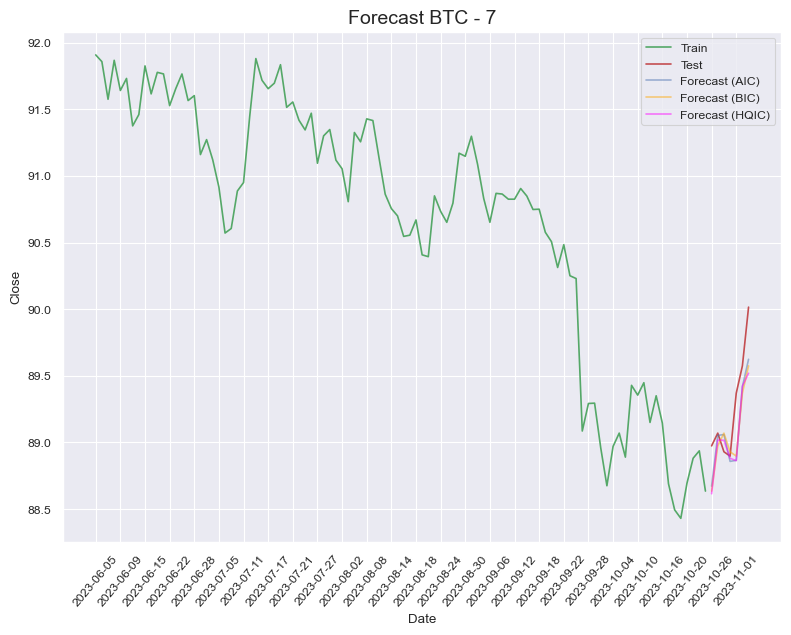

In [48]:
# Visualizar resultados
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=dates_train_7[-100:], y=train_7[-100:], label="Train", color='g')
sns.lineplot(x=test_dates_7, y=test_7, label="Test", color='r')
sns.lineplot(x=test_dates_7, y=predictions_aic_7, label="Forecast (AIC)", color='b',  alpha=0.5)
sns.lineplot(x=test_dates_7, y=predictions_bic_7, label="Forecast (BIC)", color='orange',  alpha=0.5)
sns.lineplot(x=test_dates_7, y=predictions_hqic_7, label="Forecast (HQIC)", color='magenta', alpha=0.5)
freq = int(4)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::freq])
plt.title("Forecast BTC - 7", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Horizonte 14**

In [36]:
# Dividir datos entreamiento y test
n_test_14 = 14
train_size_14 = len(BTC_df) - n_test_14

train_14 = BTC_df['Close'].iloc[:train_size_14]
dates_train_14 = BTC_df['Date'].iloc[:train_size_14]
test_14 = BTC_df['Close'].iloc[train_size_14:]
test_dates_14 = BTC_df['Date'].iloc[train_size_14:]
print("train:", train_14.shape)
print("test:", test_14.shape)

# Calcular los mejores órdenes y modelos ARIMA para AIC, BIC Y HQIC
best_order_aic, best_mdl_aic, best_order_bic, best_mdl_bic, best_order_hqic, best_mdl_hqic = find_best_arima_order(train_14, pq_rng, d_rng)
print(f"AIC: {best_order_aic}, BIC: {best_order_bic}, HQIC: {best_order_hqic}")

# Evaluar el modelo utilizando AIC o BIC
accuracy_aic_14, predictions_aic_14 = evaluate_arima_model(train_14, test_14, best_order_aic)
print("AIC Accuracy:", accuracy_aic_14)
accuracy_bic_14, predictions_bic_14 = evaluate_arima_model(train_14, test_14, best_order_bic)
print("BIC Accuracy:", accuracy_bic_14)
accuracy_hqic_14, predictions_hqic_14 = evaluate_arima_model(train_14, test_14, best_order_hqic)
print("HQIC Accuracy:", accuracy_hqic_14)

train: (630,)
test: (14,)
AIC: (3, 1, 2), BIC: (0, 1, 0), HQIC: (4, 2, 4)
Predicted=89.084453, Expected=88.690000
Predicted=88.659810, Expected=88.494100
Predicted=88.536394, Expected=88.430500
Predicted=88.473595, Expected=88.694100
Predicted=88.682733, Expected=88.881400
Predicted=88.821271, Expected=88.937000
Predicted=88.909976, Expected=88.635000
Predicted=88.672416, Expected=88.974400
Predicted=89.052858, Expected=89.069800
Predicted=89.059100, Expected=88.930000
Predicted=88.857787, Expected=88.897500
Predicted=88.865843, Expected=89.369200
Predicted=89.417813, Expected=89.574600
Predicted=89.623795, Expected=90.015000
AIC Accuracy:                    MAE       MSE      MAPE      RMSE        R2
Horizonte 14  0.215359  0.065149  0.002421  0.255242  0.624191
Predicted=89.145000, Expected=88.690000
Predicted=88.690000, Expected=88.494100
Predicted=88.494100, Expected=88.430500
Predicted=88.430500, Expected=88.694100
Predicted=88.694100, Expected=88.881400
Predicted=88.881400, Expec

Los resultados indican que, para el horizonte de 14 días, el modelo ARIMA con órdenes AIC (3, 1, 2) tiene un mejor rendimiento en términos de métricas de precisión, con un R2 más alto y un RMSE más bajo en comparación con el modelo BIC (0, 1, 0). Esto sugiere que el modelo ARIMA con órdenes AIC es más adecuado para la predicción a 14 días en este conjunto de datos.

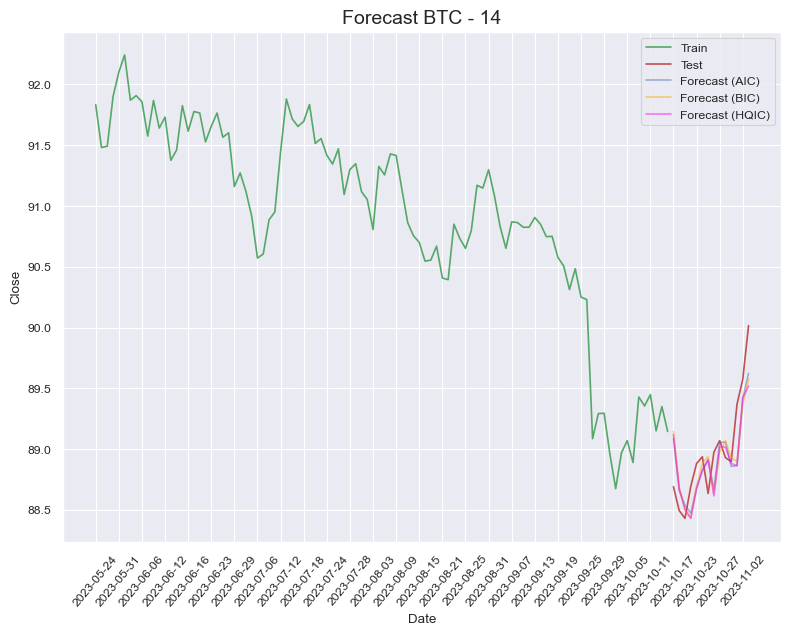

In [49]:
# Visualizar resultados
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=test_dates_14, y=test_14, label="Test", color='r')
sns.lineplot(x=test_dates_14, y=predictions_aic_14, label="Forecast (AIC)", color='b',  alpha=0.5)
sns.lineplot(x=test_dates_14, y=predictions_bic_14, label="Forecast (BIC)", color='orange',  alpha=0.5)
sns.lineplot(x=test_dates_14, y=predictions_hqic_14, label="Forecast (HQIC)", color='magenta', alpha=0.5)
freq = int(4)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::freq])
plt.title("Forecast BTC - 14", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Horizonte 21**

In [50]:
# Dividir datos entreamiento y test
n_test_21 = 21
train_size_21 = len(BTC_df) - n_test_21

train_21 = BTC_df['Close'].iloc[:train_size_21]
dates_train_21 = BTC_df['Date'].iloc[:train_size_21]
test_21 = BTC_df['Close'].iloc[train_size_21:]
test_dates_21 = BTC_df['Date'].iloc[train_size_21:]
print("train:", train_21.shape)
print("test:", test_21.shape)

# Calcular los mejores órdenes y modelos ARIMA para AIC, BIC Y HQIC
best_order_aic, best_mdl_aic, best_order_bic, best_mdl_bic, best_order_hqic, best_mdl_hqic = find_best_arima_order(train_21, pq_rng, d_rng)
print(f"AIC: {best_order_aic}, BIC: {best_order_bic}, HQIC: {best_order_hqic}")

# Evaluar el modelo utilizando AIC o BIC
accuracy_aic_21, predictions_aic_21 = evaluate_arima_model(train_21, test_21, best_order_aic)
print("AIC Accuracy:", accuracy_aic_21)
accuracy_bic_21, predictions_bic_21 = evaluate_arima_model(train_21, test_21, best_order_bic)
print("BIC Accuracy:", accuracy_bic_21)
accuracy_hqic_21, predictions_hqic_21 = evaluate_arima_model(train_21, test_21, best_order_hqic)
print("HQIC Accuracy:", accuracy_hqic_21)

train: (623,)
test: (21,)
AIC: (3, 1, 2), BIC: (0, 1, 0), HQIC: (4, 2, 4)
Predicted=89.086141, Expected=88.889700
Predicted=88.840577, Expected=89.428400
Predicted=89.402537, Expected=89.355000
Predicted=89.346332, Expected=89.448100
Predicted=89.499989, Expected=89.150100
Predicted=89.182677, Expected=89.350000
Predicted=89.349833, Expected=89.145000
Predicted=89.084453, Expected=88.690000
Predicted=88.659810, Expected=88.494100
Predicted=88.536394, Expected=88.430500
Predicted=88.473595, Expected=88.694100
Predicted=88.682733, Expected=88.881400
Predicted=88.821271, Expected=88.937000
Predicted=88.909976, Expected=88.635000
Predicted=88.672416, Expected=88.974400
Predicted=89.052858, Expected=89.069800
Predicted=89.059100, Expected=88.930000
Predicted=88.857787, Expected=88.897500
Predicted=88.865843, Expected=89.369200
Predicted=89.417813, Expected=89.574600
Predicted=89.623795, Expected=90.015000
AIC Accuracy:                    MAE       MSE      MAPE      RMSE        R2
Horizonte

Según el criterio AIC, se seleccionó un modelo más complejo (3, 1, 2) que arrojó métricas que incluyen un MAE de 0.2224, un MSE de 0.0715, un MAPE de 0.0025 y un RMSE de 0.2674, con un R2 de 0.5061. Por otro lado, el criterio BIC optó por un modelo más simple (0, 1, 0) con métricas ligeramente inferiores, incluyendo un MAE de 0.2303, un MSE de 0.0743, un MAPE de 0.0026, un RMSE de 0.2725 y un R2 de 0.4870. En resumen, el modelo AIC exhibió un rendimiento ligeramente superior en términos de precisión de pronóstico en este horizonte de 21 días en comparación con el modelo BIC.

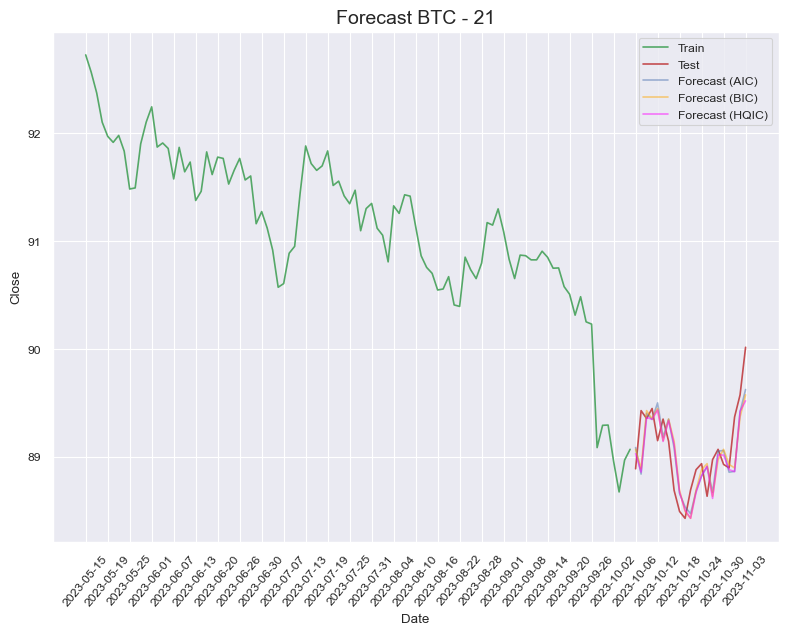

In [53]:
# Visualizar resultados
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=dates_train_21[-100:], y=train_21[-100:], label="Train", color='g')
sns.lineplot(x=test_dates_21, y=test_21, label="Test", color='r')
sns.lineplot(x=test_dates_21, y=predictions_aic_21, label="Forecast (AIC)", color='b', alpha=0.5)
sns.lineplot(x=test_dates_21, y=predictions_bic_21, label="Forecast (BIC)", color='orange', alpha=0.5)
sns.lineplot(x=test_dates_21, y=predictions_hqic_21, label="Forecast (HQIC)", color='magenta', alpha=0.5)
freq = int(4)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::freq])
plt.title("Forecast BTC - 21", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Horizonte 28**

In [56]:
# Dividir datos entreamiento y test
n_test_28 = 28
train_size_28 = len(BTC_df) - n_test_28

train_28 = BTC_df['Close'].iloc[:train_size_28]
dates_train_28 = BTC_df['Date'].iloc[:train_size_28]
test_28 = BTC_df['Close'].iloc[train_size_28:]
test_dates_28 = BTC_df['Date'].iloc[train_size_28:]
print("train:", train_28.shape)
print("test:", test_28.shape)

# Calcular los mejores órdenes y modelos ARIMA para AIC, BIC Y HQIC
best_order_aic, best_mdl_aic, best_order_bic, best_mdl_bic, best_order_hqic, best_mdl_hqic = find_best_arima_order(train_28, pq_rng, d_rng)
print(f"AIC: {best_order_aic}, BIC: {best_order_bic}, HQIC: {best_order_hqic}")

# Evaluar el modelo utilizando AIC o BIC
accuracy_aic_28, predictions_aic_28 = evaluate_arima_model(train_28, test_28, best_order_aic)
print("AIC Accuracy:", accuracy_aic_28)
accuracy_bic_28, predictions_bic_28 = evaluate_arima_model(train_28, test_28, best_order_bic)
print("BIC Accuracy:", accuracy_bic_28)
accuracy_hqic_28, predictions_hqic_28 = evaluate_arima_model(train_28, test_28,best_order_hqic)
print("HQIC Accuracy:", accuracy_hqic_28)

train: (616,)
test: (28,)
AIC: (2, 1, 3), BIC: (0, 1, 0), HQIC: (4, 2, 4)
Predicted=90.252787, Expected=89.085600
Predicted=89.048388, Expected=89.292200
Predicted=89.331492, Expected=89.294600
Predicted=89.320015, Expected=88.958500
Predicted=88.899903, Expected=88.675000
Predicted=88.671269, Expected=88.970000
Predicted=89.035595, Expected=89.070000
Predicted=89.068628, Expected=88.889700
Predicted=88.838191, Expected=89.428400
Predicted=89.404525, Expected=89.355000
Predicted=89.331352, Expected=89.448100
Predicted=89.492370, Expected=89.150100
Predicted=89.201896, Expected=89.350000
Predicted=89.361601, Expected=89.145000
Predicted=89.120573, Expected=88.690000
Predicted=88.717009, Expected=88.494100
Predicted=88.543152, Expected=88.430500
Predicted=88.397613, Expected=88.694100
Predicted=88.731781, Expected=88.881400
Predicted=88.889269, Expected=88.937000
Predicted=88.893953, Expected=88.635000
Predicted=88.648499, Expected=88.974400
Predicted=89.017776, Expected=89.069800
Predic

 Según el criterio AIC, se seleccionó un modelo ARIMA (2, 1, 3), que resultó en métricas que incluyen un MAE de 0.2547, un MSE de 0.1168, un MAPE de 0.0029 y un RMSE de 0.3418, con un bajo R2 de 0.0135, lo que indica un ajuste deficiente del modelo a los datos. Por otro lado, el criterio BIC optó por un modelo más simple (0, 1, 0), que arrojó métricas ligeramente mejores en comparación con el modelo AIC, incluyendo un MAE de 0.2573, un MSE de 0.1143, un MAPE de 0.0029, un RMSE de 0.3381 y un R2 de 0.0346. En resumen, en este horizonte de 28 días, el modelo ARIMA seleccionado según el criterio BIC supera al modelo seleccionado según el criterio AIC en términos de rendimiento de pronóstico, aunque ambos modelos tienen un rendimiento modesto en general.

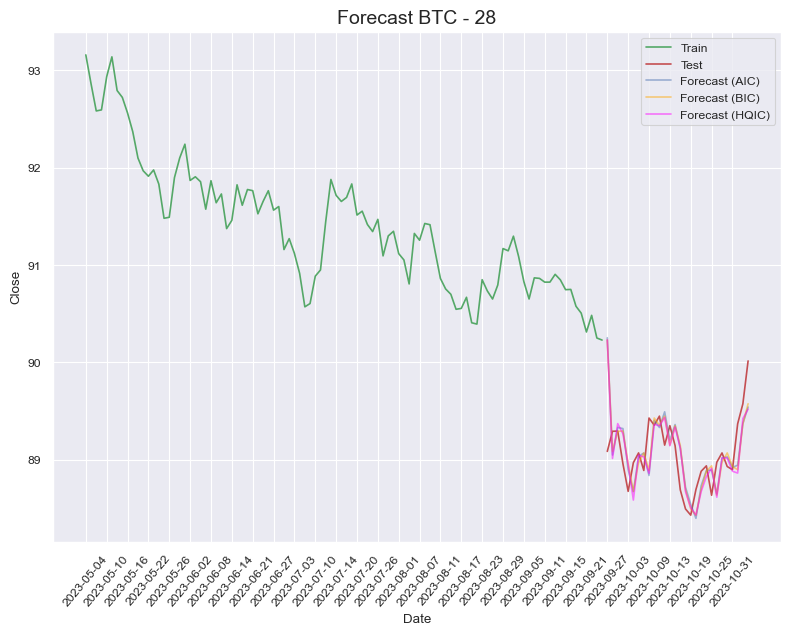

In [57]:
# Visualizar resultados
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=dates_train_28[-100:], y=train_28[-100:], label="Train", color='g')
sns.lineplot(x=test_dates_28, y=test_28, label="Test", color='r')
sns.lineplot(x=test_dates_28, y=predictions_aic_28, label="Forecast (AIC)", color='b', alpha=0.5)
sns.lineplot(x=test_dates_28, y=predictions_bic_28, label="Forecast (BIC)", color='orange', alpha=0.5)
sns.lineplot(x=test_dates_28, y=predictions_hqic_28, label="Forecast (HQIC)", color='magenta', alpha=0.5)
freq = int(4)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::freq])
plt.title("Forecast BTC - 28", fontsize=14)
plt.tight_layout()
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Errores de todos los horizontes ARIMA AIC** 

In [58]:
all_accuracies_aic= pd.concat([accuracy_aic_7, accuracy_aic_14, accuracy_aic_21, accuracy_aic_28])
print("Tabla de Métricas AIC:")
print(all_accuracies_aic.to_string())
all_accuracies_bic= pd.concat([accuracy_bic_7, accuracy_bic_14, accuracy_bic_21, accuracy_bic_28])
print("Tabla de Métricas BIC:")
print(all_accuracies_bic.to_string())
all_accuracies_hqic= pd.concat([accuracy_hqic_7, accuracy_hqic_14, accuracy_hqic_21, accuracy_hqic_28])
print("Tabla de Métricas HQIC:")
print(all_accuracies_hqic.to_string())

Tabla de Métricas AIC:
                   MAE       MSE      MAPE      RMSE        R2
Horizonte 7   0.219870  0.077245  0.002468  0.277930  0.479558
Horizonte 14  0.215359  0.065149  0.002421  0.255242  0.624191
Horizonte 21  0.222411  0.071486  0.002498  0.267368  0.506098
Horizonte 28  0.254729  0.116837  0.002855  0.341815  0.013510
Tabla de Métricas BIC:
                   MAE       MSE      MAPE      RMSE        R2
Horizonte 7   0.246371  0.086219  0.002765  0.293631  0.419094
Horizonte 14  0.231971  0.075132  0.002607  0.274102  0.566603
Horizonte 21  0.230286  0.074257  0.002587  0.272501  0.486951
Horizonte 28  0.257275  0.114336  0.002884  0.338136  0.034628
Tabla de Métricas HQIC:
                   MAE       MSE      MAPE      RMSE        R2
Horizonte 7   0.238220  0.094984  0.002675  0.308195  0.360042
Horizonte 14  0.229098  0.077624  0.002576  0.278610  0.552229
Horizonte 21  0.224101  0.076179  0.002518  0.276006  0.473670
Horizonte 28  0.257095  0.118345  0.002883  0.34

Los modelos seleccionados utilizando el criterio AIC en los primeros tres horizontes son del orden ARIMA(3, 1, 2), mientras que el criterio BIC selecciona un modelo más simple en todos los horizones, ARIMA(0, 1, 0). 

En términos de métricas de rendimiento, el modelo seleccionado por AIC suele tener un mejor rendimiento en MAE, MSE, MAPE y RMSE en horizontes de 7, 14 y 21 días. Esto sugiere que, en general, el modelo ARIMA(3, 1, 2) proporciona un ajuste más preciso a los datos en esos horizontes. 

Por su parte, para el horizonte de 28 días el modelo seleccionado por BIC tiene un rendimiento ligeramente mejor en términos de MAE y MSE. Esto puede deberse a que, en ocasiones, un modelo más simple puede ser más adecuado para pronosticar datos a largo plazo. El hecho de que ambos modelos muestren un bajo valor de R2 en el horizonte de 28 días tiene implicaciones importantes. El coeficiente de determinación (R2) indica cuánta variabilidad en los datos es explicada por el modelo. En este caso, un R2 bajo sugiere que los modelos ARIMA, ya sea ARIMA(3, 1, 2) o ARIMA(0, 1, 0), no pueden explicar gran parte de la variabilidad en los datos a largo plazo. 

**Prueba del modelo seleccionado con los horizontes**

Con base a lo descrito anteriormente, escogio el modelo (3,1,2) del criterio AIC para evaluarlo en todos los horizontes

In [ ]:
# Dividir datos en entrenamiento y prueba (excluyendo el horizonte más grande)
train_size_general = len(BTC_df) - 28
train_general = BTC_df['Close'].iloc[:train_size_general]
test_general = BTC_df['Close'].iloc[train_size_general:]

# dates_train_general = BTC_df['Date'].iloc[:train_size_general] #fechas en caso de querer graficar el resultado
# test_dates_general = BTC_df['Date'].iloc[train_size_general:]

horizontes = [7, 14, 21, 28] # Horizontes a evaluar
best_order = (3, 1, 2) # Definir el mejor modelo ARIMA AIC seleccionado manualmente
accuracy_list = [] # Para almacenar datos de metricas

for i, horizonte in enumerate(horizontes):
    test_horizonte = test_general.iloc[:horizonte] # Dividir los datos de test para el horizonte actual
    accuracy, predictions = evaluate_arima_model(train_general, test_horizonte, best_order) # Evaluar modelo en el horizonte actual
    accuracy_dict = {'Horizonte': horizonte, 'MAE': accuracy['MAE'].values[0], 'MSE': accuracy['MSE'].values[0], 'MAPE': accuracy['MAPE'].values[0], 'RMSE': accuracy['RMSE'].values[0], 'R2': accuracy['R2'].values[0]}
    accuracy_list.append(accuracy_dict)
    
accuracy_table = pd.DataFrame(accuracy_list)
print(accuracy_table)

Predicted=90.241302, Expected=89.085600
Predicted=89.048634, Expected=89.292200
Predicted=89.354084, Expected=89.294600
Predicted=89.319976, Expected=88.958500
Predicted=88.899002, Expected=88.675000
Predicted=88.671264, Expected=88.970000
Predicted=89.042723, Expected=89.070000
Predicted=90.241302, Expected=89.085600
Predicted=89.048634, Expected=89.292200
Predicted=89.354084, Expected=89.294600
Predicted=89.319976, Expected=88.958500
Predicted=88.899002, Expected=88.675000
Predicted=88.671264, Expected=88.970000
Predicted=89.042723, Expected=89.070000
Predicted=89.086141, Expected=88.889700
Predicted=88.840577, Expected=89.428400
Predicted=89.402537, Expected=89.355000
Predicted=89.346332, Expected=89.448100
Predicted=89.499989, Expected=89.150100
Predicted=89.182677, Expected=89.350000
Predicted=89.349833, Expected=89.145000
Predicted=90.241302, Expected=89.085600
Predicted=89.048634, Expected=89.292200
Predicted=89.354084, Expected=89.294600
Predicted=89.319976, Expected=88.958500
